In [1]:
# Instalar dependências
!pip install google-generativeai pandas nltk scikit-learn wordcloud matplotlib seaborn --quiet

In [2]:
# Imports
import pandas as pd
import re
import nltk
import json
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import google.generativeai as genai
from google.colab import userdata
import time

In [3]:
# Configurar API do Gemini
genai.configure(api_key=userdata.get('chave'))
model = genai.GenerativeModel('gemini-2.0-flash')

In [4]:
# Carregar dados
df = pd.read_csv('/content/drive/MyDrive/Python/analise_de_sentimentos_ONLINE/CSV/data/TwExtract-LulaOficial-20250807_134229.csv')
df.dropna(subset=['tweetText'], inplace=True)
df.head()

,id,tweetText,tweetURL,type,tweetAuthor,handle,replyCount,quoteCount,retweetCount,likeCount,views,bookmarkCount,createdAt,allMediaURL,videoURL
0,1953493558729548265,"Telefonei, hoje, para o primeiro-ministro da Í...",https://x.com/LulaOficial/status/1953493558729...,tweet,Lula,@LulaOficial,108,23,273,2036,27806,22,2025-08-07 13:28:53,NaN,NaN
1,1953255742376395066,"Assinei hoje, no Palácio do Planalto, a homolo...",https://x.com/LulaOficial/status/1953255742376...,tweet,Lula,@LulaOficial,428,27,966,6299,103100,48,2025-08-06 21:43:53,https://pbs.twimg.com/media/GxtbmLYWoAAYvlt.jp...,NaN
2,1953219052786037008,Viva a cultura brasileira 🇧🇷\n\nSancionei hoje...,https://x.com/LulaOficial/status/1953219052786...,tweet,Lula,@LulaOficial,820,51,1018,9780,150779,50,2025-08-06 19:18:05,https://pbs.twimg.com/media/Gxs6ItJWAAAX-yP.jpg,NaN
3,1953187223479742801,Nós não vamos medir esforços para proteger as ...,https://x.com/LulaOficial/status/1953187223479...,tweet,Lula,@LulaOficial,998,70,1589,7493,102420,76,2025-08-06 17:11:37,https://pbs.twimg.com/amplify_video_thumb/1953...,https://video.twimg.com/amplify_video/19531868...
4,1952890402249265166,Combater a fome e a desigualdade é uma escolha...,https://x.com/LulaOficial/status/1952890402249...,tweet,Lula,@LulaOficial,1241,46,1343,8067,122513,52,2025-08-05 21:32:09,https://pbs.twimg.com/media/GxoPX2aWkAADb1h.jpg,NaN


In [5]:
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords_pt = set(stopwords.words('portuguese'))

def limpar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r"http\S+|@\S+|#\S+|[^a-zA-Zá-úÁ-Ú0-9\s]", "", texto)
    palavras = texto.split()
    return ' '.join([p for p in palavras if p not in stopwords_pt])

df['texto_limpo'] = df['tweetText'].apply(limpar_texto)
df[['tweetText', 'texto_limpo']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,tweetText,texto_limpo
0,"Telefonei, hoje, para o primeiro-ministro da Í...",telefonei hoje primeiroministro índia narendra...
1,"Assinei hoje, no Palácio do Planalto, a homolo...",assinei hoje palácio planalto homologação terr...
2,Viva a cultura brasileira 🇧🇷\n\nSancionei hoje...,viva cultura brasileira sancionei hoje dois pr...
3,Nós não vamos medir esforços para proteger as ...,vamos medir esforços proteger empresas brasile...
4,Combater a fome e a desigualdade é uma escolha...,combater fome desigualdade escolha política me...


In [6]:
resultados = []

for i in range(0, len(df), 10):  # tamanho de lote ajustável
    trecho = df['texto_limpo'].iloc[i:i+10].tolist()

    prompt = f"""
    Você é um analista de dados. Abaixo estão tweets de uma discussão. Para cada tweet, classifique o sentimento (positivo, negativo ou neutro) e identifique o tema principal em uma frase.

    Retorne no seguinte formato JSON:
    [
      {{
        "tweet": "texto",
        "sentimento": "positivo|negativo|neutro",
        "tema": "resumo curto"
      }},
      ...
    ]

    Tweets:
    {trecho}
    """

    try:
        response = model.generate_content(
            prompt,
            generation_config={'response_mime_type': 'application/json'}
        )
        resultados.extend(json.loads(response.text))
    except Exception as e:
        print(f"Erro ao processar lote {i}-{i+10}: {e}")
        continue

    time.sleep(1)  # evita limite de chamadas

df_resultado = pd.DataFrame(resultados)
df_resultado.head()


Erro ao processar lote 10-20: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


,tweet,sentimento,tema
0,telefonei hoje primeiroministro índia narendra...,neutro,"Discussão entre Brasil e Índia sobre comércio,..."
1,assinei hoje palácio planalto homologação terr...,positivo,Homologação de terras indígenas e o reconhecim...
2,viva cultura brasileira sancionei hoje dois pr...,positivo,Sanção de leis que reconhecem o carnaval e o a...
3,vamos medir esforços proteger empresas brasile...,positivo,"Compromisso de proteger empresas, empregos e a..."
4,combater fome desigualdade escolha política me...,positivo,Combate à fome e desigualdade através de polít...


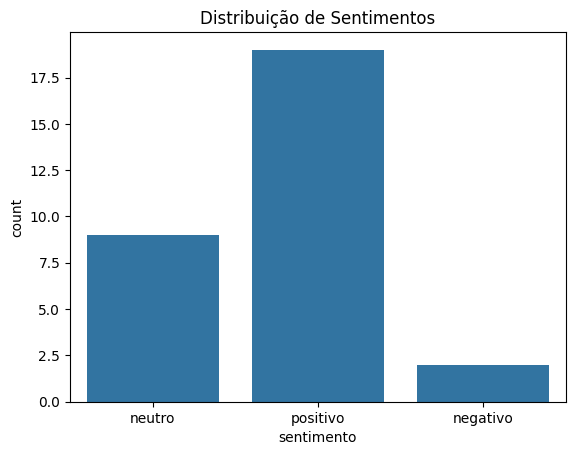

In [7]:
# Sentimentos
sns.countplot(data=df_resultado, x='sentimento')
plt.title("Distribuição de Sentimentos")
plt.show()

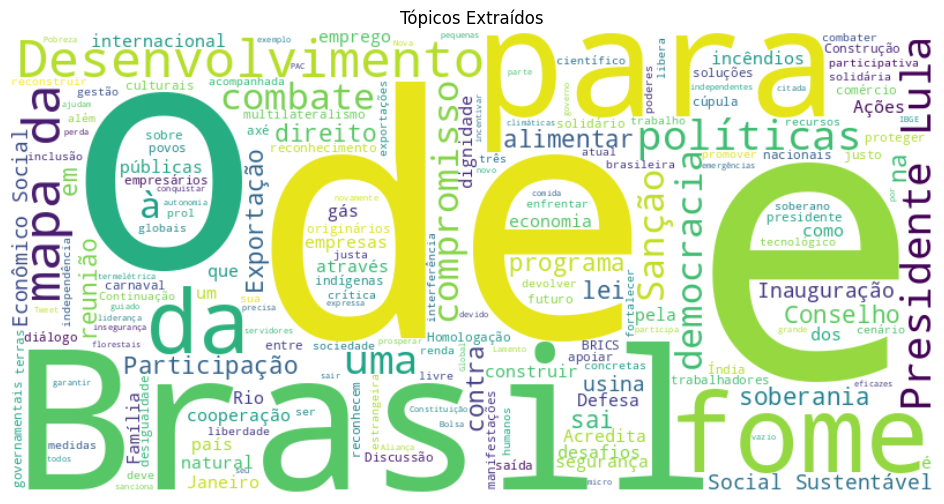

In [8]:
# Nuvem de palavras dos temas
textao = ' '.join(df_resultado['tema'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(textao)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Tópicos Extraídos')
plt.show()

In [9]:
df_resultado.to_csv('tweets_analisados.csv', index=False)